# Análisis de los descriptores WHIM

In [1]:
import numpy as np
import pandas as pd
import pytraj as pyt
import glob, os

In [2]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [17:34:58] Enabling RDKit 2019.09.1 jupyter extensions


### Se carga la tabla de datos de la CDK2
**Se lee la tabla de datos de las conformaciones con la información de los ligandos y las etiquetas según el tipo de conformación (activa/inactiva) de la protreína.** 

In [3]:
# Nombre de la proteina de interes
prot_name = 'cdk2'
path_to_json_file = glob.glob((os.path.join('.', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS_AUC_docking_DUD.json')))[0]
df_cdk2_labels = pd.read_json(path_to_json_file)

### Formato de las moléculas

<div style='background-color: #F5A566; padding: 5px 12px;'>Antes de cargar las moléculas, debemos convertirlas a un formato que sea correctamente leído con rdkit.</div>

**Para ello en necesario considerar lo siguiente:**

Los archivos pueden ser leídos a partir de dos fuentes:
1. **`sdf` desde un pdb:** Desde un archivo pdb sin Hs, usando: `obabel -ipdb file.pdb -osdf file.sdf -p 7.4`
2. **`sdf` desde uel mol2:** Desde el archivo mol2 generado con `Chimera` que ya ha sido protonado con este mismo programa, usando: `obabel -imol2 file.mol2 -osdf file.sdf`. Es importante no usar el parámetro `-p`

```bash
# Usamos obabel 
cd "../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP"
for mol in `ls *pdb`
do 
    name=${mol%.*}
    # Directamente desde el archivo pdb sin Hs
    obabel -ipdb $mol -osdf -O ${name}_from_pdb.sdf -p 7.4 # Añade Hs a ph fisiológico
done

mv *sdf ../LIGS_POSES_SDF/

cd "../LIGS_PREP_IN_POCKET"
for mol in `ls *mol2`
do 
    name=${mol%.*}
    # directamente desde el archivo mol2 generado con chimera y sin el parámetro -p
    obabel -imol2 $mol -osdf -O ${name}_from_mol2.sdf
done

mv *sdf ../LIGS_POSES_SDF/
```

Cuando la molécula provenga desde un archivo *pdbqt* o *pdb* de docking, el proceso para obtener los archivos superiores es primero remover los hidrógenos de la molécula y luego añadirlos con `Chimera` o `babel` (en teoría, antes del docking se habría hecho el mismo proceso para tener el estado de protonación correcto). Finalemente se guardará la molécula en un archivo **`mol2`** que correspoonde al solicitado en el punto #1 de la lista anterior.

## Ligandos cocristalizados
### Las moléculas son cargadas en formato SDF
**Se genera lista con los _paths_ de los archivos cocristalizados.**

In [4]:
path_crys_poses = "../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_POSES_SDF/"
files_pose_crys = sorted( glob.glob(path_crys_poses + "*_from_pdb.sdf") ) # Ligandos generados con chimera
# El número de ligandos a evaluar
print(F'Número de archivos de ligandos a cargar: {len(files_pose_crys)}')

Número de archivos de ligandos a cargar: 365


### Cargamos las moléculas con *rdkit*
Usamos el siguiente bloque de código que emplea el método `Chem.SDMolSupplier` de `rdkit` para cargar cada uno de los ligandos cocristalizados con la proteína.

<div>
<span style='font-weight: bold;'>Desde un archivo mol2 no funcionará</span>  si la molécula tiene ciclos que no siguen el estándar de corina ('C.ar' o 'N.ar'), u oxígenos unidos a fósforo debido a que rdkit no reconoce los Oxígenos O.c2 en archivos mol2 generados por babel o Chimera (formatos distintos al estpandar 'corina' que sigue rdkit).<br>El problema no parece poder resolverse sustituyendo, por ejemplo, 'C.ar' por 'C.2', pues manualmente hay que elegir qué átomos deben tener un enlace sp2 (C=C) o sp3 (C-C) dentro del ciclo. <a src='https://sourceforge.net/p/rdkit/mailman/message/28665746/'>Fuente</a>.
    </div>

Para ello se crea un diccionario con los objetos correspondientes a cada molécula.


In [5]:
# Cargamos los ids y nombre de los ligandos ordenados en una lista
pdbId_lig_dic = {file.split("/")[-1].split("_")[0]: file.split("/")[-1].split("_")[1] 
               for file in files_pose_crys}

<div style='background-color: #F9E5AB; padding: 5px 12px; font-size: 1.2em;'>El proceso de carga de las moléculas es el siguiente:</div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #F5B75D; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Se intenta cargar desde el archivo sdf generado a partir del pdb original con obabel.</span>
    Esto resuleve el problema con los archivos mol2, y garantiza que la carga de los grupos fosfato sea respetada. A cambio, este paso genera problemas de valencia en átomos de N y C dentro de ciclos debido a la conectividad de éstos. De no ser por los fosfatos, podríamos saltar de este paso al siguiente.
    </li>
      <li class="list-group-item"><span style='background-color: #F5975D; padding: 5px;'>2)</span>
      <span style='font-weight: bold;'>Se intenta cargar desde el archivo sdf generado a partir del mol2 con Hidrógenos.</span>
    Este paso resuelve el probela del anterior.
    </li>
     <li class="list-group-item"><span style='background-color: #EB624C; padding: 5px;'>3)</span>
      <span style='font-weight: bold;'>Se intenta cargar desde el archivo sdf generado a partir del mol2 con Hidrógenos pero sin sanitizar la molécula.</span>
    En este punto el problema del punto 2) no se resuelve en el paso 3) con lo cual aún existen átomos con una valencia inadecuada (carbonos pentavalentes o nitrógenos hexavalentes), con lo cual se fuerza a rdkit a no sanitizar la molécula y se usa UpdatePropertyCache() para después poder calcular los descriptores WHIM.
         <a src='https://www.wildcardconsulting.dk/the-good-the-bad-and-the-ugly-rdkit-molecules/'>Fuente</a>.
    </li>
    </li>
</ol>

In [6]:
# Cargamos los archivos en un diccionario u
ligs_cdk2_dic = {}
ligs_validation_dic = {}

for file in files_pose_crys:
    pdb_id = file.split("/")[-1].split("_")[0]
    # Primer intento, carga el sdf generado directamente con babel a partir del pdb sin Hs
    mol_list = Chem.SDMolSupplier(file, sanitize = True)
    ligs_cdk2_dic[pdb_id] = mol_list[0]
    ligs_validation_dic[pdb_id] = 'v1'
    # Segundo intento, se carga el sdf desde el mol2
    if ligs_cdk2_dic[pdb_id] is None:
        file = file.replace('_pdb.sdf', '_mol2.sdf')
        mol_list = Chem.SDMolSupplier(file, sanitize = True)
        ligs_cdk2_dic[pdb_id] =  mol_list[0]
        ligs_validation_dic[pdb_id] = 'v2'
        # Finalmente, si esto último no es posible, se omite a sanitización, este es el peor de los casos
        # porque hay que forzar a ser más laxo en la validación del compuesto
        if ligs_cdk2_dic[pdb_id] is None:
            # La molécula seguirá siendo leida desde el sdf generado a partir del mol2
            mol_list = Chem.SDMolSupplier(file, sanitize = False)
            mol = mol_list[0]
            mol.UpdatePropertyCache(strict = False)
            ligs_cdk2_dic[pdb_id] =  mol
            ligs_validation_dic[pdb_id] = 'v3'

RDKit ERROR: [17:35:02] Explicit valence for atom # 18 C greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 66
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 18 C greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 63
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 76
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 79
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 0 N, 4, is greater tha

RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 104
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 102
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 109
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not san

RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 71
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 4 C greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 5 C greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 99
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 5 C greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 5 C greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 86
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 5 C greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 17 C greater than permitted
RDKit ERROR: [17:35:02] ERROR: Could not sanitize molecule ending on line 88
RDKit ERROR: [17:35:02] ERROR: Explicit valence for atom # 17 C greater than permitted
RDKit ERROR: [17:35:02] Explicit valence for atom # 6 C greater than permitted
RDKit ERROR: [17:35:02] ERROR:

Una vez cargadas las moléculas verificamos que sea posiblecalcular los descriptores a las moléculas.

In [7]:
for i, j in ligs_cdk2_dic.items():
    try:
        Chem.rdMolDescriptors.CalcWHIM(j)
    except(RuntimeError):
        print('La molécula no fue cargada adecuadamente.')
print('Finalizado')

Finalizado


#### Comparación entre archivos SDF y PDB
Sólo a modo de ejemplo lo comparamos con un archivo PDB.

In [8]:
# Cargamos un archivo pdb como prueba
_pdb_prueba = Chem.MolFromPDBFile("../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP/1b38_ATP_LIG.pdb")

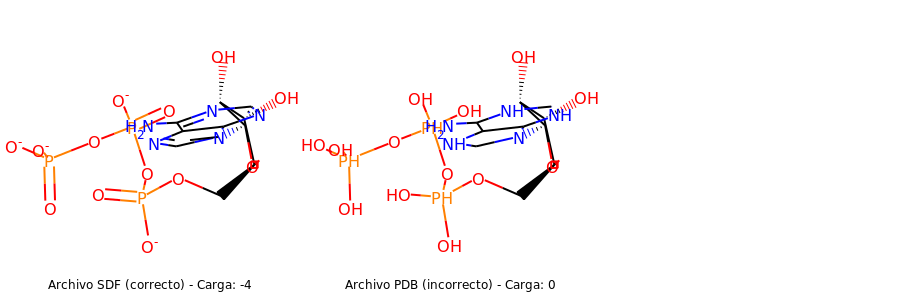

In [9]:
# visualización con rdkit
cargas_ = [Chem.rdmolops.GetFormalCharge(i) for i in [ligs_cdk2_dic['1b38'], _pdb_prueba]]
Chem.Draw.MolsToGridImage([ligs_cdk2_dic['1b38'], _pdb_prueba],
                         legends = [F'Archivo SDF (correcto) - Carga: {cargas_[0]}', 
                                    F'Archivo PDB (incorrecto) - Carga: {cargas_[1]}'],
                         subImgSize = (300, 300))

#### Visualización en 2d

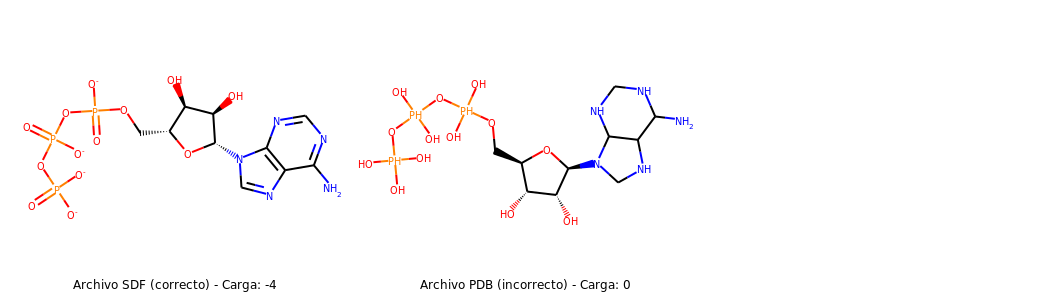

In [10]:
import copy
a_ = copy.copy(ligs_cdk2_dic['1b38']); b_ = copy.copy(_pdb_prueba)
for i in [a_, b_]: AllChem.Compute2DCoords(i)
Chem.Draw.MolsToGridImage([a_, b_],
                     legends = [F'Archivo SDF (correcto) - Carga: {cargas_[0]}', 
                                    F'Archivo PDB (incorrecto) - Carga: {cargas_[1]}'],
                     subImgSize = (350, 300))

La carga neta del **ATP** a pH 7.4 es de -3. [Ver fuente en Zinc15](http://zinc15.docking.org/substances/ZINC000004261765/)

## DataFrame con las Moléculas
#### Creamos un Dataframe a partir del diccionario.
En este punto se crea un **Dataframe** que permita vincular cada objeto de rdkir con el nombre de la molécula, el PDB id al que pertenece y al archivo del ligando.

In [11]:
# Lista de PDBIds y sus ligandos
df_crys_poses_rdk = pd.DataFrame.from_dict(pdbId_lig_dic, orient='index', columns=["Lig"])
# Se añaden las rutas a losarchivos pdb
df_crys_poses_rdk["mol_rdk"] = [i for i in ligs_cdk2_dic.values()]
df_crys_poses_rdk["file"] = files_pose_crys
df_crys_poses_rdk["Labels_conf"] = df_cdk2_labels.loc[pdbId_lig_dic.keys()].Labels_conf
df_crys_poses_rdk["Validation"] = ligs_validation_dic.values()
# Visualizamos parte del dataframe
df_crys_poses_rdk.head(5)

,Lig,mol_rdk,file,Labels_conf,Validation
1aq1,STU,<rdkit.Chem.rdchem.Mol object at 0x7fce0b62e350>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_POSES_SDF...,inact_b,v1
1b38,ATP,<rdkit.Chem.rdchem.Mol object at 0x7fce0b62d670>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_POSES_SDF...,inact_a,v1
1b39,ATP,<rdkit.Chem.rdchem.Mol object at 0x7fce0b438620>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_POSES_SDF...,inact_a,v1
1ckp,PVB,<rdkit.Chem.rdchem.Mol object at 0x7fce0b62e3a0>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_POSES_SDF...,inact_a,v1
1di8,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7fce0b62e620>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_POSES_SDF...,inact_a,v1


Número de moléculas que no pudieron ser sanitizadas:

In [12]:
df_crys_poses_rdk.Validation.value_counts()

v1    212
v2    119
v3     34
Name: Validation, dtype: int64

#### Para accesar directamente a una molécula:

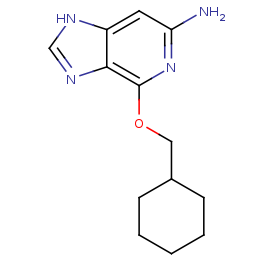

Lig                207
Labels_conf    inact_a
Name: 1h0w, dtype: object


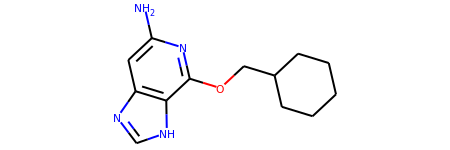

In [17]:
from IPython.display import Image
import requests, copy

id_ = '1h0w'
lig_name = df_crys_poses_rdk.loc[id_, 'Lig']
# Imagen comparativa proporcionada por el PDB
url = F'https://cdn.rcsb.org/etl/ligand/img/{lig_name[0:1]}/{lig_name}/{lig_name}-270.png'
pil_img = Image(requests.get(url).content)
display(pil_img)

print(df_crys_poses_rdk.loc[id_, ['Lig', 'Labels_conf']])
g = copy.copy(df_crys_poses_rdk.loc[id_, 'mol_rdk'])
AllChem.Compute2DCoords(g)
g

***
<div style='background-color: #F9E5AB; padding: 5px 12px; font-size: 1.2em;'><h1 class='text-danger'>Descriptores WHIM
<small class="text-muted">Weighted Holistic Invariant Molecular descriptors</small>
</h1>
    </div>

- Los descriptores WHIM son **descriptores geométricos (3D)**.
- Se construyen de tal forma que capturan información tridimencional relacionada con el tamaño molecular, la forma, la simetría y la distribución atómica.  
- La molécula es representada como una **configuración de puntos** (los átomos) en un espacio tridimencional definido por los ejes $x, y, z$.
- En términos generales su cálculo consiste en **centrar las coordenadas de los átomos** de la molécula, **calcular la matriz de covarianzas** de las coordenadas ($S_{qq'}$) y calcular los **eigenvalores** de dicha matriz:

$$S_{qq'} = \frac{\sum_{i=1}^{A}w_i (q_i - \overline{q}) (q'_i - \overline{q}')}{\sum_{i=1}^{A}w_i},$$

> donde $q_i$ y $q'_i$ son coordenadas atómicas ($x, y, z$) del átomo $i$, $\overline{q}$ y $\overline{q}'$ son las medias de las coordenadas, $A$ es el número de átomos, $w_i$ es un 'peso' o porpiedad según el tipo de átomo.
- Cada eigenvalor ($\lambda_1, \lambda_2, \lambda_3$) de la matriz de covarianzas representa una medida de dispersión de los átomos proyectados en cada uno de los 3 ejes principales. Esta dispersión y distribución atómica en los ejes principales es depués evaluada en cada uno de los descriptores.

- **Se dividen en dos clases principales:**
    - Descriptores Axiales o Direccionales
    - Descriptores Globales
- Los descriptores direccionales son calculados a apartir de los eigenvalores de la matriz de covarianzas.
- Los descriptores globales son una combinación de los direccionales.

Los descriptores:
- **Axiales o Direccionales:**
    - $L_k$ : Dimensión axial (k = 1, 2, 3)
    - $P_k$ : Forma axial (k = 1, 2); rdkit omite el k = 3
    - $G_k$ : Simetria axial (k = 1, 2, 3)
    - $E_k$ : Densidad axial (k = 1, 2, 3)  
<br>
- **Globales:**
    - $T$ : Dimensión Global
    - $A$ : Dimensión Global
    - $G$ : Simetría Global
    - $K$ : Forma Global
    - $D$ : Densidad Global
    - $V$ : Dimensión Global
    
- Los descriptores son invariantes a la traslación y a la rotación de la molécula. Invariante a la traslación porque las coordenadas de los átomos son centralizadas, e invariantes a la rotación, por la eigendescomposición de la matirz de covarianzas y la proyección en los eigenvectores resultantes.

Las propiedades atómicas, o pesos, **_w_** son las siguientes (todos son escalados con respecto a un átomo de Carbono):
- **_u_** : _unweighted_
- **_m_** : _Atomic mass_
- **_v_** : _van der Waals Volume_
- **_e_** : _Sanderson Electronegativity_
- **_p_** : _Atomic polarizability_
- **_s_** : _Electropological satate indices of Kier and Hall_
- **_i_** : _Topologycal I-state_

### Calculamos los descriptores WHIM para las moléculas
Creamos una **matriz donde cada fila corresponde a una molécula y las 114 características corresponden a las 114 propiedades** que calcula *rdkit*, las cuales son las mismas que calcula el software *Dragon*.

In [69]:
df_crys_poses_rdk.head(6)

,Lig,mol_rdk,file,Labels_conf
1aq1,STU,<rdkit.Chem.rdchem.Mol object at 0x7f60f0ef6120>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_SDF_...,inact_b
1b38,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f60f0ef6850>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_SDF_...,inact_a
1b39,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f60f0ef67b0>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_SDF_...,inact_a
1ckp,PVB,<rdkit.Chem.rdchem.Mol object at 0x7f60f0ef68a0>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_SDF_...,inact_a
1di8,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7f60f0ef6990>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_SDF_...,inact_a
1dm2,HMD,<rdkit.Chem.rdchem.Mol object at 0x7f60f0ef6710>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_SDF_...,inact_b


``` python
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')
from modules import dimorphite_dl
```

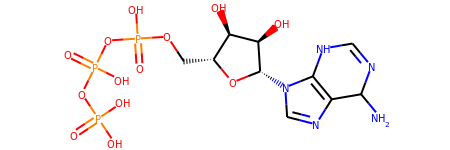

In [24]:
k = Chem.SDMolSupplier('/home/joel/Escritorio/atp_from_mol2_NUEVO.sdf', 
                       sanitize = True); k=k[0]
AllChem.Compute2DCoords(k)
k

In [79]:
a = df_crys_poses_rdk.loc['1e1x', 'mol_rdk']
Chem.rdMolDescriptors.CalcWHIM(a)

RuntimeError: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 171 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2019.09.1
	BOOST: 1_67


In [503]:
# No funciona el formato pdb
# k = Chem.MolFromPDBFile('/home/joel/Escritorio/1e1x_h.pdb', sanitize = True)


# k = Chem.MolFromMol2File('/home/joel/Escritorio/1e1x_h_chim_from_pdb.mol2', sanitize = True)
# k = Chem.MolFromMol2File('/home/joel/Escritorio/1ex_mol2_from_pdb_babel.mol2', sanitize = True)

# Convertido de mol2de chimera a sdf con obabel
k = Chem.SDMolSupplier('/home/joel/Escritorio/1e1x_from_mol2_ph.sdf', sanitize = True, removeHs=False); k=k[0]

#k = Chem.SDMolSupplier('/home/joel/Escritorio/1ex_sdf_from_mol2_babel.sdf', sanitize = True, removeHs=False); k=k[0]

# no funciona convertir de pdb sin hs (raw) a sdf con obabel
# k = Chem.SDMolSupplier('/home/joel/Escritorio/1e1x_from_raw_pdb.sdf', sanitize = True); k=k[0]

# Workflow que funciona con 1e1x. Con quimera añadir Hs al pdb sin Hs, luego guardar como mol2
# también funciona convertir con obabel ese mol2, guardado con chimera, a sdf

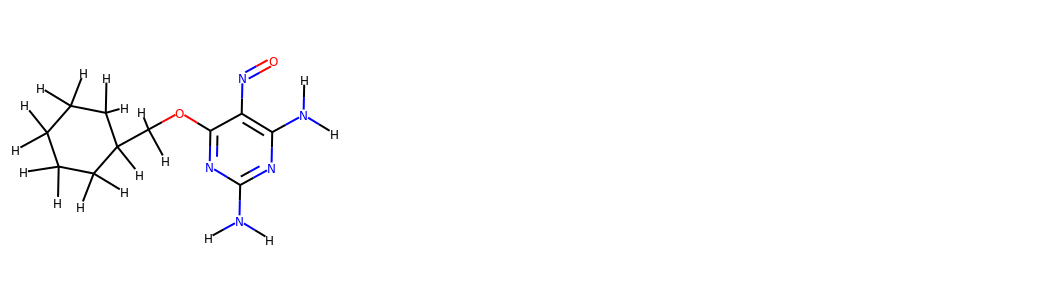

In [504]:
#k = copy.copy(s[0])

Chem.rdMolDescriptors.CalcWHIM(k)

#k.UpdatePropertyCache(strict = False)
# Chem.rdmolops.RemoveHs(k)
AllChem.Compute2DCoords(k)

Chem.Draw.MolsToGridImage([k],
                     subImgSize = (350, 300))


In [467]:
Chem.MolFromMol2File('/home/joel/Escritorio/atp_mol2_from_raw_pdb.mol2', sanitize = True)

RDKit WARNING: [19:15:48] 1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.


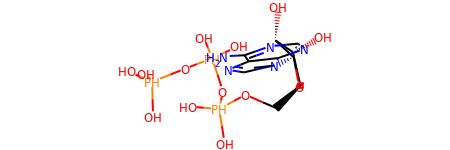

In [516]:
# No funciona directamente de pdb raw a mol2 con chimera
# k = Chem.MolFromMol2File('/home/joel/Escritorio/atp_chim_h.mol2', sanitize = True)

# Convertido de mol2de chimera a sdf con obabel
h = Chem.SDMolSupplier('/home/joel/Escritorio/atp_sdf_from_mol2_babel.sdf', 
                       sanitize = True); h=h[0]
h

0


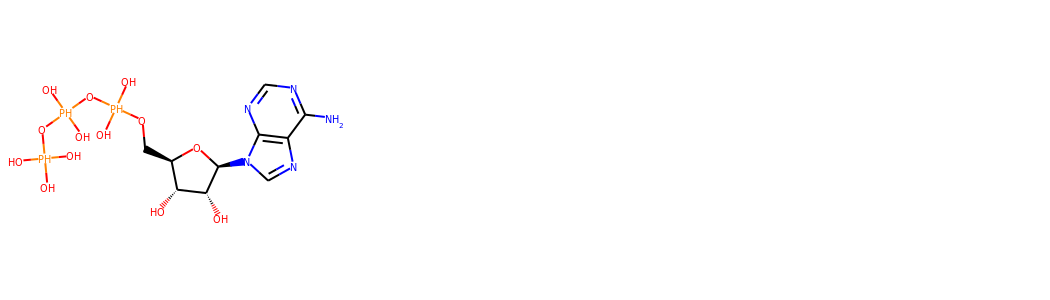

In [517]:
#k = copy.copy(s[0])
#k.UpdatePropertyCache(strict = False)
#Chem.rdmolops.RemoveHs(k)
AllChem.Compute2DCoords(h)

print(Chem.rdmolops.GetFormalCharge(h))
Chem.Draw.MolsToGridImage([h],
                     subImgSize = (350, 300))

In [426]:
f = Chem.SDMolSupplier('/home/joel/Escritorio/yyy.sdf', 
                         sanitize = True)

# Chem.rdMolDescriptors.CalcWHIM(k)
f = f[0]
#f.UpdatePropertyCache(strict = False)
# Chem.rdmolops.RemoveHs(k)
AllChem.Compute2DCoords(f)

Chem.Draw.MolsToGridImage([f], subImgSize = (350, 300))

OSError: File error: Bad input file /home/joel/Escritorio/yyy.sdf

In [269]:

k = Chem.MolFromMol2File('/home/joel/Escritorio/zzz.mol2')


# Chem.rdMolDescriptors.CalcWHIM(k)

k.UpdatePropertyCache(strict = False)
# Chem.rdmolops.RemoveHs(k)
AllChem.Compute2DCoords(k)

Chem.Draw.MolsToGridImage([k],
                     subImgSize = (350, 300))

RDKit WARNING: [17:06:26] 1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.


AttributeError: 'NoneType' object has no attribute 'UpdatePropertyCache'

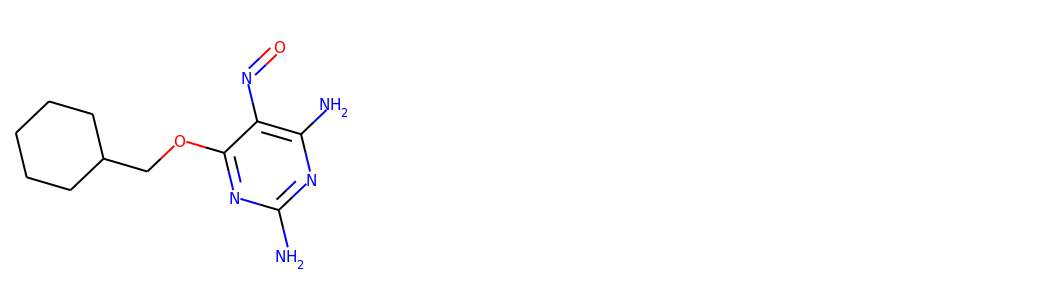

In [175]:

k = Chem.MolFromMol2File('/home/joel/1e9h_INR_LIG.mol2')


# Chem.rdMolDescriptors.CalcWHIM(k)

k.UpdatePropertyCache(strict = False)
# Chem.rdmolops.RemoveHs(k)
AllChem.Compute2DCoords(k)

Chem.Draw.MolsToGridImage([k],
                     subImgSize = (350, 300))

In [117]:
k

In [174]:
s = Chem.SDMolSupplier('../ARCHIVOS/CRISTALES/LIGS_CDK2/IN_POCKET_NON_PREP/1e1x_NW1_LIG.sdf', 
                       sanitize = False)
k = copy.copy(s[0])

Chem.rdMolDescriptors.CalcWHIM(k)

k.UpdatePropertyCache(strict = False)
# Chem.rdmolops.RemoveHs(k)
AllChem.Compute2DCoords(k)

Chem.Draw.MolsToGridImage([k],
                     subImgSize = (350, 300))

RuntimeError: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 171 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2019.09.1
	BOOST: 1_67


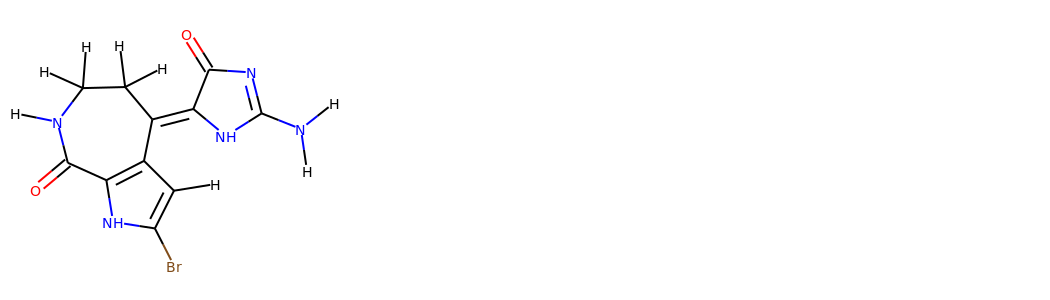

In [60]:
s = Chem.SDMolSupplier('../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_SDF_REDUCED/1dm2_HMD_LIG_no_inizado.sdf', 
                       sanitize = False)
k = copy.copy(s[0])
k.UpdatePropertyCache(strict = False)

AllChem.Compute2DCoords(k)


Chem.Draw.MolsToGridImage([k],
                     subImgSize = (350, 300))

HMD


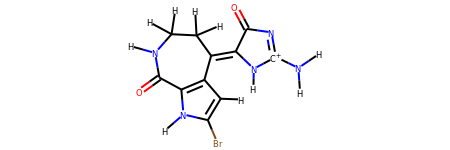

In [51]:
# https://sourceforge.net/p/rdkit/mailman/message/29261087/
print(df_crys_poses_rdk.iloc[5, 0])
df_crys_poses_rdk.iloc[5, 1].UpdatePropertyCache(strict = False)
Chem.rdMolDescriptors.CalcWHIM(df_crys_poses_rdk.iloc[5, 1])
x_ = copy.copy(df_crys_poses_rdk.iloc[5, 1])
AllChem.Compute2DCoords(x_)
x_

In [55]:
n_moleculas = len(df_crys_poses_rdk.index)
whim_array = np.empty((n_moleculas, 114))

for i, mol in enumerate(df_crys_poses_rdk.mol_rdk):
    print(i)
    whim_mol = Chem.rdMolDescriptors.CalcWHIM(mol)
    whim_array[i] = whim_mol

0
1
2
3
4
5


RuntimeError: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 171 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2019.09.1
	BOOST: 1_67


Esta  es las lista de descriptores que calcula *rdkit*.

In [9]:
whim_axial = [ "L1u", "L2u", "L3u", "P1u", "P2u", "G1u", "G2u", "G3u", "E1u", "E2u", "E3u", 
               "L1m", "L2m", "L3m", "P1m", "P2m", "G1m", "G2m", "G3m", "E1m", "E2m", "E3m", 
               "L1v", "L2v", "L3v", "P1v", "P2v", "G1v", "G2v", "G3v", "E1v", "E2v", "E3v", 
               "L1e", "L2e", "L3e", "P1e", "P2e", "G1e", "G2e", "G3e", "E1e", "E2e", "E3e", 
               "L1p", "L2p", "L3p", "P1p", "P2p", "G1p", "G2p", "G3p", "E1p", "E2p", "E3p", 
               "L1i", "L2i", "L3i", "P1i", "P2i", "G1i", "G2i", "G3i", "E1i", "E2i", "E3i", 
               "L1s", "L2s", "L3s", "P1s", "P2s", "G1s", "G2s", "G3s", "E1s", "E2s", "E3s"]
whim_global = ["Tu", "Tm", "Tv", "Te", "Tp", "Ti", "Ts", 
               "Au", "Am", "Av", "Ae", "Ap", "Ai", "As", 
               "Gu", "Gm", 
               "Ku", "Km", "Kv", "Ke", "Kp", "Ki", "Ks", 
               "Du", "Dm", "Dv", "De", "Dp", "Di", "Ds", 
               "Vu", "Vm", "Vv", "Ve", "Vp", "Vi", "Vs"]

#### Creamos el DataFrame con las 365 moléculas y los 114 desciptores

In [10]:
df_whim = pd.DataFrame(whim_array, index = df_pdb_ligs.index)
df_whim.columns = whim_axial + whim_global

Visualizamos la matriz de correlación de los descriptores. Como puede observarse hay patrones de correlación entre los descriptores que se diferencian únicamente por los esquemas de peso usados.

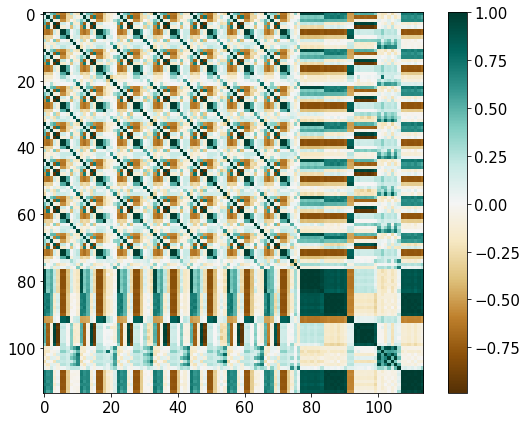

In [11]:
%matplotlib inline

fig = plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 15})
plt.imshow( df_whim.corr(), cmap='BrBG')
plt.colorbar();

***
### Selección de características
Importamos las librerías de **sklearn** que vamos a utilizar para hacer la selección de los descriptores finales.

In [12]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

In [13]:
#Estandarizamos
if False:
    scaler = StandardScaler()
    df_whim[df_whim.columns] = scaler.fit_transform(df_whim[df_whim.columns])

- **Eliminando características constantes o poco variables.**

In [35]:
#Eliminando características constantes
umbral_var = 0.001
constant_filter = VarianceThreshold(threshold = umbral_var)
constant_filter.fit( df_whim )
non_const_columns = df_whim.columns[constant_filter.get_support()]

print(F'Número de características a conservar: {len(non_const_columns)}\nSu varianza es mayor a {umbral_var}.')

Número de características a conservar: 98
Su varianza es mayor a 0.001.


In [36]:
df_whim_no_const = df_whim[non_const_columns]
df_whim_no_const.head(5)

,L1u,L2u,L3u,P1u,P2u,G3u,E1u,E2u,E3u,L1m,...,Dp,Di,Ds,Vu,Vm,Vv,Ve,Vp,Vi,Vs
1aq1,7.055,6.592,0.574,0.496,0.464,0.165,0.560,0.509,0.220,7.143,...,0.312,0.387,0.335,95.243,96.377,93.868,96.361,92.425,96.050,83.125
1b38,14.627,3.017,1.072,0.782,0.161,0.168,0.537,0.444,0.306,15.008,...,0.359,0.447,0.345,129.040,128.184,119.394,136.450,105.957,134.649,97.375
1b39,15.143,2.971,1.157,0.786,0.154,0.168,0.540,0.430,0.307,15.540,...,0.357,0.443,0.341,137.255,136.863,126.726,145.415,112.378,143.401,101.990
1ckp,9.851,1.338,0.323,0.856,0.116,0.193,0.581,0.507,0.451,10.938,...,0.590,0.502,0.418,32.549,40.035,33.804,33.414,35.072,32.473,29.241
1di8,13.308,3.023,0.010,0.814,0.185,0.186,0.536,0.379,0.298,13.525,...,0.343,0.417,0.338,57.162,59.616,55.138,59.596,52.744,58.066,47.071


In [37]:
# Removiendo caracteristicas duplicadas
# Verificamos si hay columnas identicas
df_whim_no_const.T.duplicated().sum()

0

In [51]:
# Eliminando características correlacioneadas
correlated_features = set()
corr_mat_whim = df_whim_no_const.corr()

for row in range(len(corr_mat_whim)):
    for col in range(row):
        if abs(corr_mat_whim.iloc[row, col]) > 0.7:
            colname = corr_mat_whim.columns[row]
            correlated_features.add(colname)
len(correlated_features)

85

In [52]:
#correlated_features

In [53]:
# Eliminamos las características con mayor correlación
df_whim_final = df_whim_no_const.drop(labels=correlated_features, axis=1)

In [54]:
df_whim_final.columns

Index(['L1u', 'L2u', 'L3u', 'G3u', 'E1u', 'E2u', 'E3u', 'E1m', 'E2m', 'E1s',
       'E2s', 'E3s', 'Ds'],
      dtype='object')

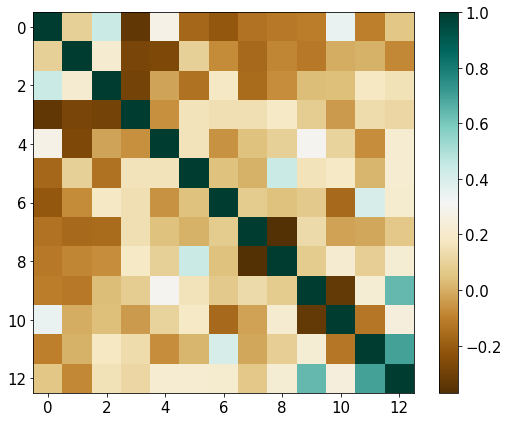

In [55]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 15})
plt.imshow(df_whim_final.corr(), cmap='BrBG')
plt.colorbar();

#### Análisis de Componentes Principales

In [56]:
from sklearn.decomposition import PCA
from modulos.plotting_functions import plot_mds_or_pca, plot_anotation_labels

pca_whim = PCA(copy=True, n_components= 2).fit_transform( df_whim_final )

In [57]:
ligand_labels = ["red" if i else "none" for i in df_pdb_ligs.Lig == "ATP"]
len(ligand_labels)

365

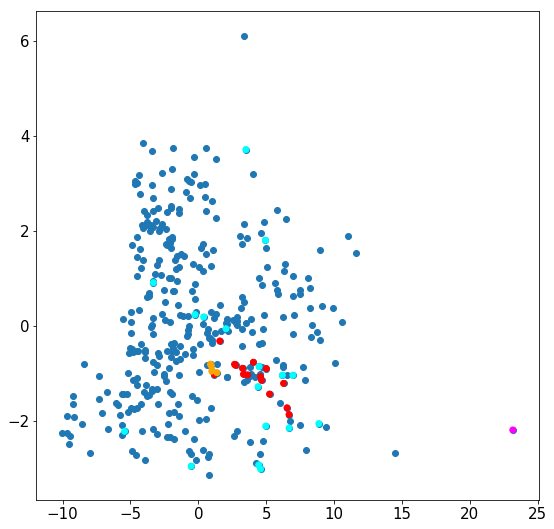

In [58]:
label_ATP = ["red" if i else "none" for i in df_pdb_ligs.Lig == "ATP"]
label_ADP = ["orange" if i else "none" for i in df_pdb_ligs.Lig == "ADP"]
label_STU = ["magenta" if i else "none" for i in df_pdb_ligs.index == "5a14"]

lista_csar = ["4ek4", "4ek5", "4fkg", "4fki", "4ek6", "4fjk", "4fkl", "4ek8", "3sw4", "3sw7", 
              "4fko", "4fkp", "4fkq", "4fkr", "4fks", "4fkt", "4fku", "4fkv", "4fkw"]
#lista_csar = ["4fku", "4fkw"]
label_csar = ["cyan" if i in lista_csar else "none" for i in df_pdb_ligs.index]

fig = plt.figure(figsize=(9, 9))
#plot_mds_or_pca(mds = pca_whim.T, alpha = 0.8, colors_list=ligand_labels, general_font_size= 20)
plt.scatter(pca_whim.T[0], pca_whim.T[1])
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_ATP)
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_csar)
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_ADP)
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_STU);


In [63]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components= 2, n_neighbors=10).fit_transform( df_whim_final )

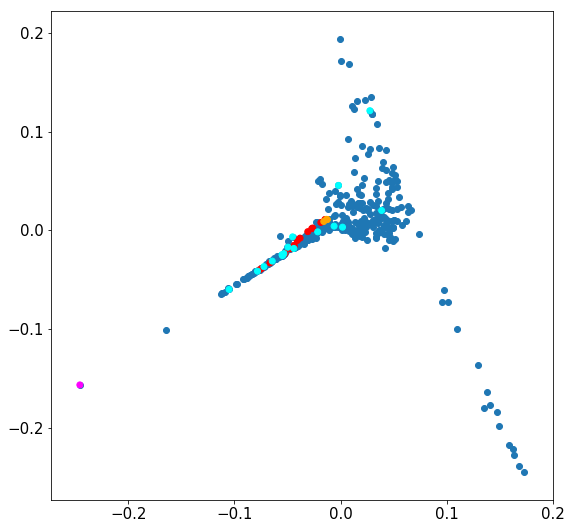

In [64]:
fig = plt.figure(figsize=(9, 9))
#plot_mds_or_pca(mds = pca_whim.T, alpha = 0.8, colors_list=ligand_labels, general_font_size= 20)
plt.scatter(lle[:,0], lle[:,1])
plt.scatter(lle[:,0], lle[:,1], color=label_ATP)
plt.scatter(lle[:,0], lle[:,1], color=label_ADP)
plt.scatter(lle[:,0], lle[:,1], color=label_csar)
plt.scatter(lle[:,0], lle[:,1], color=label_STU);


In [95]:
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
whim_final = scaler.fit_transform(df_whim_final)
D = distance_matrix(whim_final, whim_final)

In [96]:
from scipy.spatial.distance import euclidean
import scipy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
whim_final = scaler.fit_transform(df_whim_final)

leng = whim_final.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = euclidean(whim_final[i], whim_final[j])

In [97]:
D.shape

(365, 365)

In [98]:
from modulos.MDS import cMDS
mds = cMDS(D)

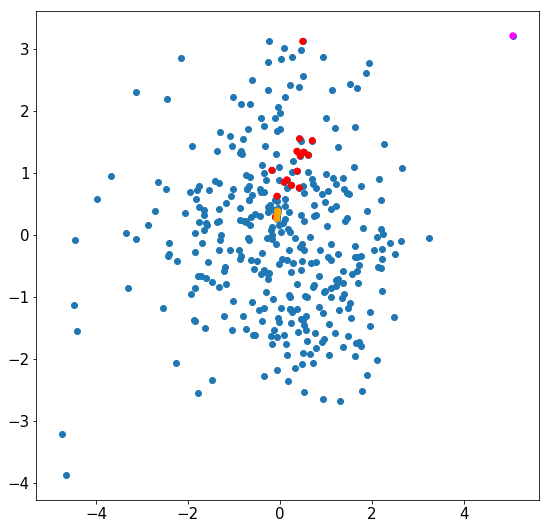

In [99]:
fig = plt.figure(figsize=(9, 9))
plt.scatter(mds[0][0], mds[0][1])
plt.scatter(mds[0][0], mds[0][1], color=label_ATP)
plt.scatter(mds[0][0], mds[0][1], color=label_ADP)
plt.scatter(mds[0][0], mds[0][1], color=label_STU)